# 支持向量机

本教程改编自 [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/05.07-Support-Vector-Machines.ipynb)。

支持向量机是一种强大且灵活的监督学习算法，可以用于分类和回归任务，在本次教程中，我们将分析其原理并将其用于分类任务。

首先import一些基本的库。其中`seaborn`是一个基于`matplotlib`的数据可视化库，提供了一些更高层的方法，我们后续用seaborn画出分类任务的混淆矩阵。

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 准备工作

考虑一个简单的分类任务，即两类数据点能够使用一条直线分开:

首先生成一些随机的点，并画出散点图。

其中，`plt.scatter()`参数中`s`为点的尺寸。`c`可以和`cmap`结合使用不同类别的样本赋予不同颜色。

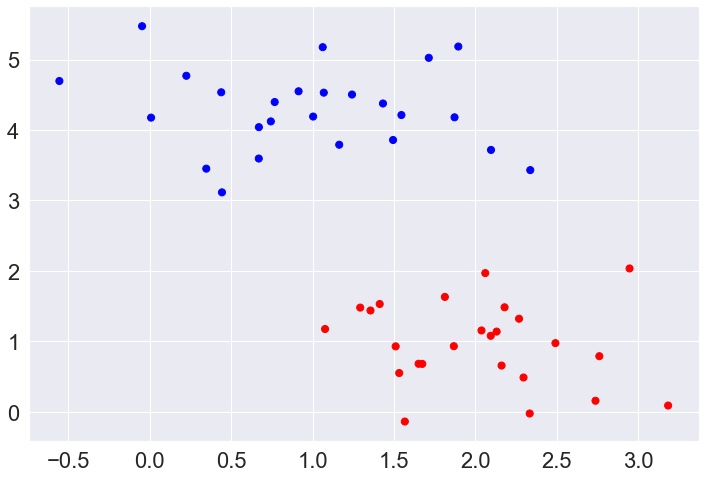

In [46]:
from sklearn.datasets._samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2, 
                  cluster_std=0.60, random_state=0)
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], s=50, c=y, cmap='bwr')

线性判别分类器会用一条直线将两类数据点分来，对于上述这种二维的数据，我们可以手动画出一些可能的分类界面：

(-1.0, 3.5)

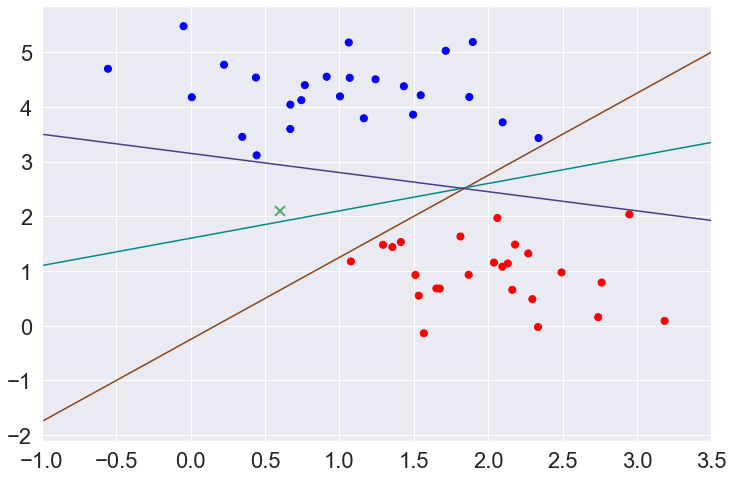

In [47]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plt.plot([0.6], [2.1], 'x', color='g', markeredgewidth=2, markersize=10)

for m, b, c in [(1.5, -0.25, 'saddlebrown'), (0.5, 1.6, 'darkcyan'), (-0.35, 3.15, 'darkslateblue')]:
    plt.plot(xfit, m * xfit + b, c)

plt.xlim(-1, 3.5)

以上三条直线都可以准确地将两类数据点分开，但选择不同的直线，图中标记`"×"`的点将属于不同的类别，显然，仅仅在"不同类之间画一条分类线"是不够的，我们需要再深入思考。

## 支持向量机: 最大间隔分类器

支持向量机提供了一种改进的方法，其核心是：相比于简单地在不同类之间画一条零宽度的直线，我们可以在分界线周围画一个有宽度的间隔，其范围的延伸到距离最近的点。


例如，对于刚才的例子，我们分别画出三个分类界面到样本之间的范围区间：

(-1.0, 3.5)

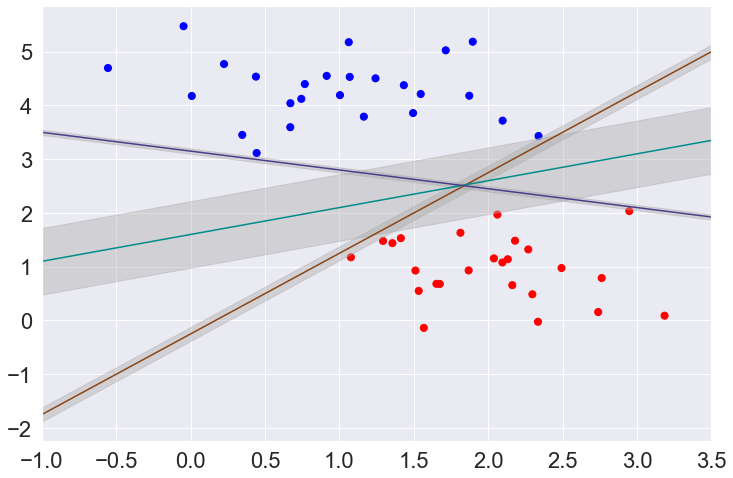

In [48]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')

for m, b, c, d in [(1.5, -0.25, 'saddlebrown', 0.13), (0.5, 1.6, 'darkcyan', 0.62), (-0.35, 3.15, 'darkslateblue', 0.05)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, c)
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

我们直观上感觉更好的分类界面，其与样本之间的间隔区间更大。

支持向量机是一种**最大间隔分类器**，能够最大化分类界面与样本之间的间隔。

### 支持向量机拟合

我们将使用Scikit-Learn的`SVC`（支持向量分类器）来训练这组数据。

我们首先使用线性核并将"正则化参数$C$"设置为一个非常大的数字，构建一种**硬间隔SVM**，并使用之前的样本对其进行训练。

In [49]:
from sklearn.svm import SVC  # "Support vector classifier"
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

我们定义一个可视化函数来绘制SVM预测的分类界面：

In [50]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',edgecolors='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

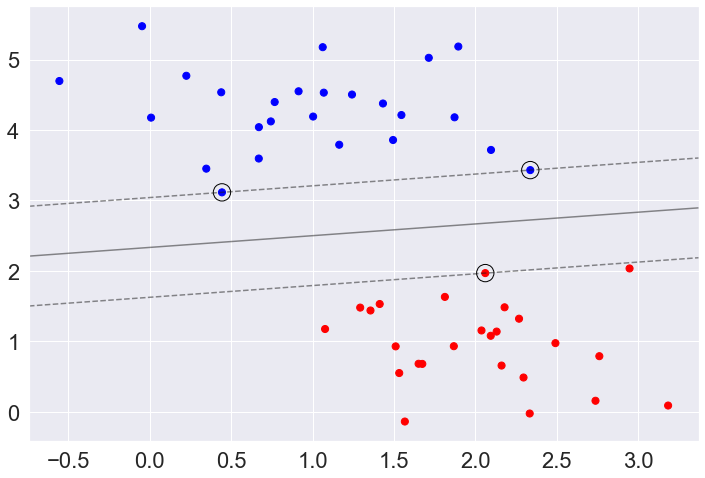

In [51]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(model)

上图实线是使得两类数据有最大间隔的分类界面。有几个数据样本在间隔边界上:它们由图中的黑色圆圈表示。这些样本即为支持向量。

在Scikit-Learn中，这些点存储在分类器的支持向量（`support_vectors_`）属性中

In [52]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

支持向量机的特点为：只有支持向量对分界面起决定作用，而支持向量之外的样本不对分界面产生影响。

例如，当我们分别使用60个样本和120个样本训练SVM模型，如果新增加的60个样本中没有新的支持向量，那么得到的分界面也不会发生变化。

这种特性使得SVM对远处的噪声点有更好的适应能力。

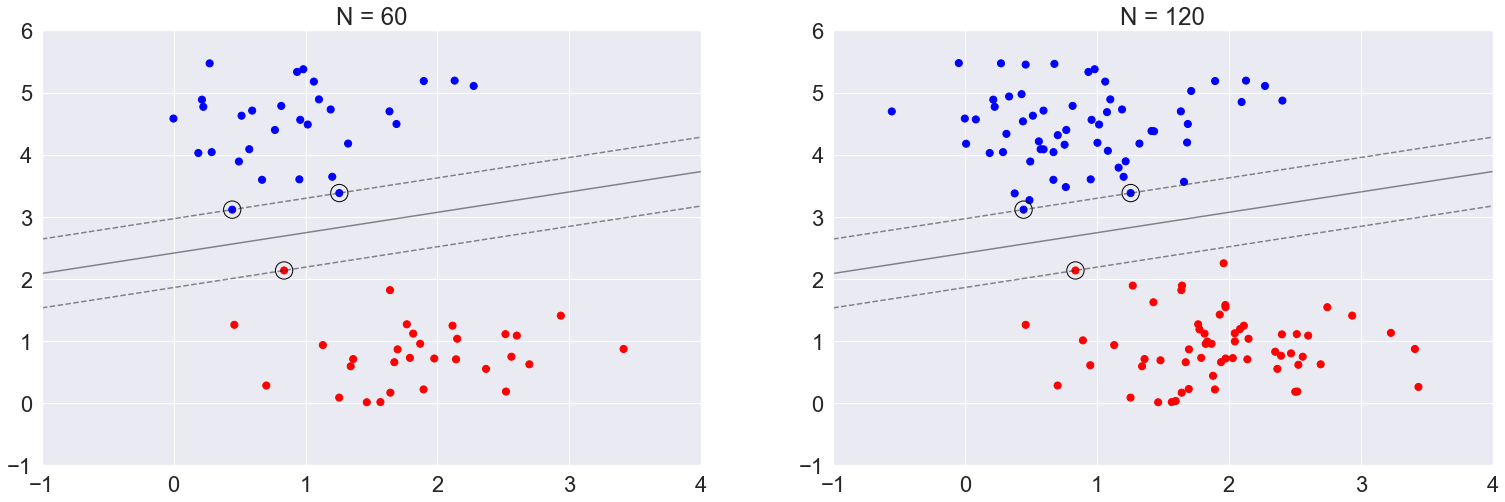

In [53]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(26, 8))
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### 非线性边界: 核函数法

上述使用线性核的SVM只能解决线性可分问题，当线性不可分时，SVM需要结合核函数。

首先生成两类线性不可分的环状样本。

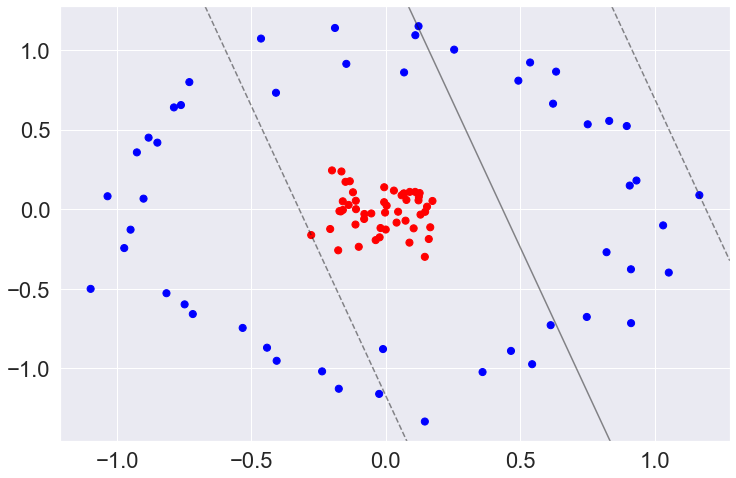

In [54]:
from sklearn.datasets._samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1, random_state=0)

model = SVC(kernel='linear').fit(X, y)

plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(model, plot_support=False)

很明显，任何线性分界面别法都无法将这些数据分离出来。但是，当数据被映射到更高的维度后，可能会拥有更好的线性可分性。

其中，高斯核，又称径向基函数核(radial basis function kernel, `rbf`)，是一种常用的核函数。

它的映射方式为：$K(\bm{x}, \bm{x}') = exp(-\gamma||\bm{x} - \bm{x}'||_2^2)$，其中$\gamma=\frac{1}{2\sigma^2}$为可调节的参数。

In [55]:
model = SVC(kernel='rbf', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0)

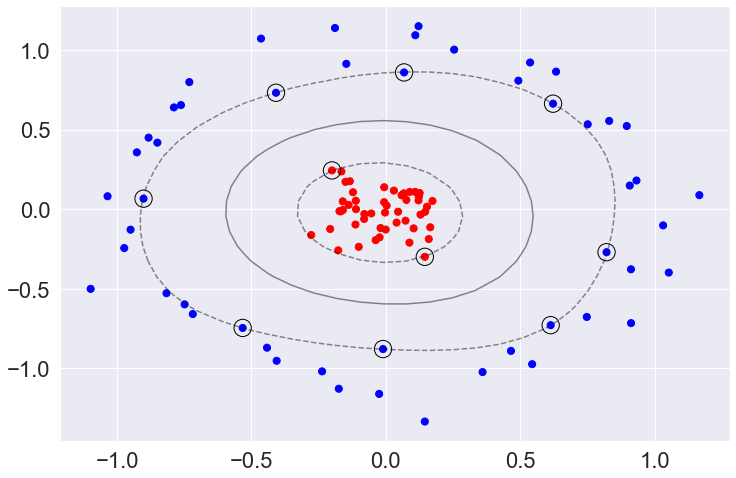

In [56]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
plot_svc_decision_function(model)

### 引入正则化参数的支持向量机

到目前为止，我们的讨论集中在理想的数据集上，它存在一个完美的决策边界把不同类别的数据分开。

但是实际情况中，不同类的样本之间通常有一些重叠，导致难以找到完全理想的分类边界。

例如，我们在数据中添加更多的噪声，得到下列样本：

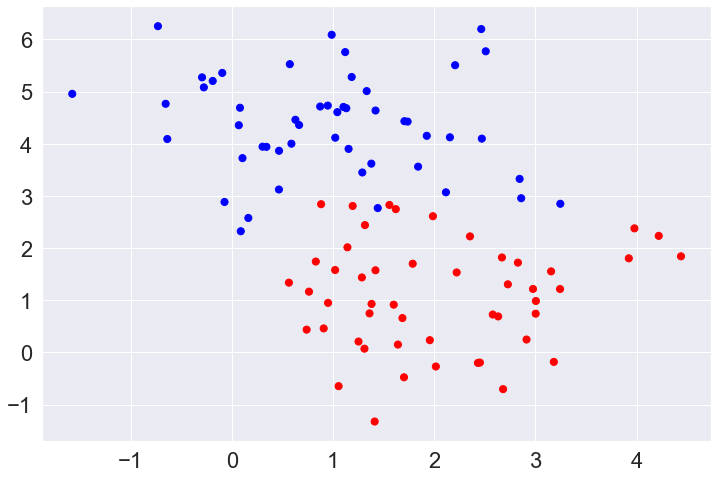

In [57]:
X, y = make_blobs(n_samples=100, centers=2,
                  cluster_std=1., random_state=0)
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')

为了处理这种情况，SVM引入正则化参数$C$，它允许部分样本位于间隔区间以获得更好地泛化性。

$C$越大，代表SVM对分类正确性的要求越严格，进入间隔的点越少。

下面的图表给出了一个可视化的图片，通过改变$C$参数可影响支持向量的选取，从而获得不同的分类界面和间隔区间:

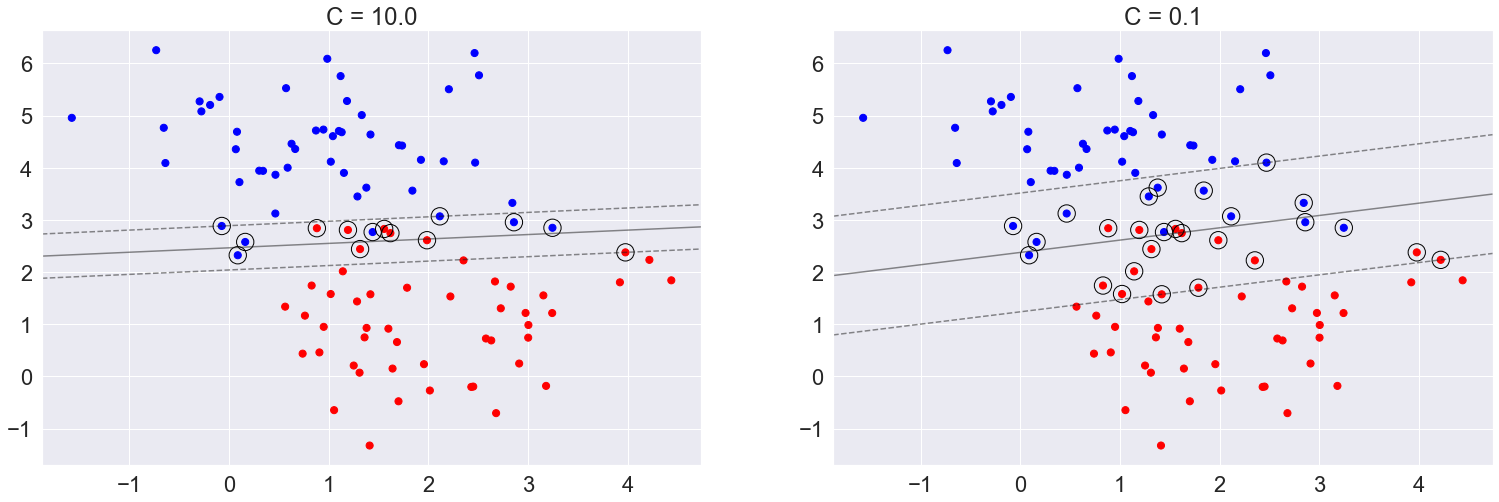

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(26, 8))

for axi, C in zip(ax, [10, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
    plot_svc_decision_function(model, axi)
    axi.set_title('C = {0:.1f}'.format(C), size=24)

对于不同数据集，$C$参数的最佳取值并不固定，可以使用**交叉验证**等方式进行对$C$`进行调优。

## SVM实战：人脸识别

让我们来看看将支持向量机应用于人脸识别问题。

我们将使用Labeled Faces in the Wild (LFW)人脸识别数据集，该数据集包含数千张人脸图像。

本教程将LFW数据集中的部分样本放置在'faces.pkl'文件中，该文件可以通过pickle库中的pickle.load()方法进行读取。

（注：pickle库通常用于Python对象与字节流的相互转换，即将数据保存为二进制文件，或从二进制文件中读取数据）

In [59]:
import pickle
with open('faces.pkl', 'rb')  as f:
    faces = pickle.load(f)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


让我们可视化其中一部分数据:

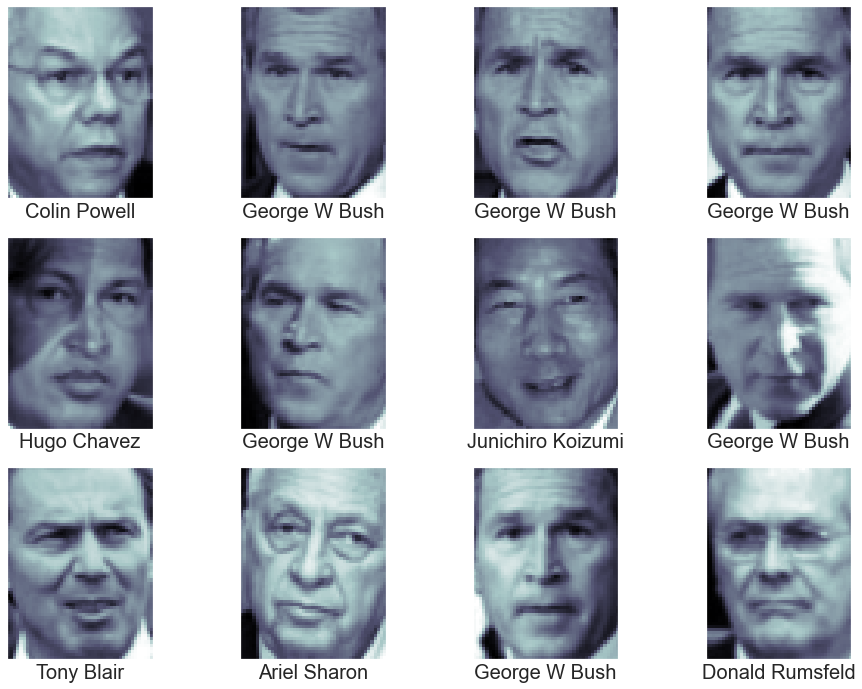

In [60]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.xaxis.get_label().set_fontsize(20)
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

每幅图像的尺寸为62×47像素。我们将把数据按3:1的比例分成训练集和测试集：

In [61]:
from sklearn.model_selection import  train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                test_size=0.25, random_state=42)

我们可以简单地将每个像素值作为一个特征，但通常可以使用额外的特征提取方法来获得对图像更高效的特征表示。

本教程使用主成分分析（PCA）对图像进行降维，并选取前150个主成分获得150维的图像特征，作为SVM的输入。

Scikit-Learn库同时提供了`PCA`和一种组合不同模块形成整体模型的方法`make_pipeline`。

In [62]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

其中，PCA参数中`svd_solver=randomized`表示在PCA的计算过程中使用[Halko等人提出的方法](https://epubs.siam.org/doi/10.1137/090771806)进行SVD分解，它比传统的SVD具有更高的效率，适用于大规模实际问题。

SVM的参数`class_weight=balanced`，表示对每一类样本的正则化参数$C$按样本比例进行缩放，使得第$i$类样本对应的$C_i$与该类样本数量成反比，即
$C_i = \frac{n \cdot C}{m \cdot n_i}$，其中$n$为训练样本总数，$n_i$为第$i$类样本的数量，$m$为类别总数。

为了寻找SVM合适的超参数（例如正则化参数$C$和高斯核参数$\gamma$），我们可以使用网格搜索交叉验证来探索不同超参数的组合。

对于刚刚建立好的模型`model`，我们可以打印出默认的正则化参数$C$和高斯核参数$\gamma$：

In [63]:
print('C = ', model.get_params()['svc__C'])
print('gamma = ', model.get_params()['svc__gamma'])

C =  1.0
gamma =  scale


可以发现Scikit-Learn中的SVM，其默认的正则化参数$C=1.0$，而高斯核参数$\gamma=$ scale。

其中，scale的含义为，高斯核参数$\gamma$将根据输入样本数据进行调整，即

$\gamma = 1 / (d \cdot var_x)$

使用输入数据的方差$var_x$和特征维度$d$对$\gamma$进行初始化。

现在，我们可以使用Scikit-Learn中的`GridSearchCV`方法对正则化参数$C$和高斯核参数$\gamma$进行设定，并对不同参数组合下的模型进行调优。

In [64]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 10, 20],
              'svc__gamma': [1e-4, 1e-3, 1e-2]}
grid = GridSearchCV(model, param_grid)

# jupyter可以通过在需要运行的代码前加上%time的方式，输出该行代码的运行时间
# wall time指从计算机程序开始到结束所经历的实际时间，与cpu time不同，cpu time指处理器积极处理某项任务的时间。
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

Wall time: 11.8 s
{'svc__C': 10, 'svc__gamma': 0.001}


可以发现最优值为

$C = 10$, $\gamma = 1e-3$

该最优值落在搜索范围的中间。通常，如果最优值落在搜索范围的边缘，我们需要扩大范围，以确保找到最优结果。

现在，使用这个最优模型对测试集图像进行预测:

In [65]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

让我们来看看一些测试图像以及它们的预测值:

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

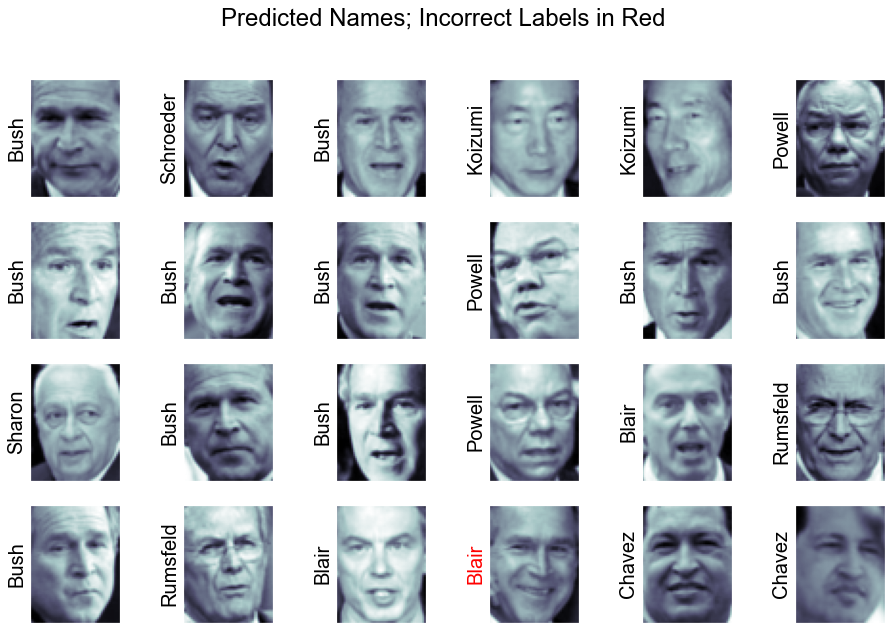

In [66]:
plt.rc('font', size=12)
fig, ax = plt.subplots(4, 6, figsize=(16, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1], fontsize=20,
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=24, color='black')

可以看到，我们只错标了一张脸(最下面一排的布什的脸被错标为布莱尔)。

我们可以使用分类报告来更好地了解我们的分类器的性能:

In [67]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

         accuracy                           0.85       337
        macro avg       0.83      0.84      0.84       337
     weighted avg       0.86      0.85      0.85       337



support表示测试集样本的数量。

precision, recall, f1-score分别为精确率、召回率和F1分数。

accuracy为分类准确率。macro avg为每个指标的算术平均值。weighted avg是使用每类样本数量的加权平均值。

我们还可以显示这些类之间的混淆矩阵来分析哪些类别容易发生混淆。:

Text(122.02, 0.5, 'predicted label')

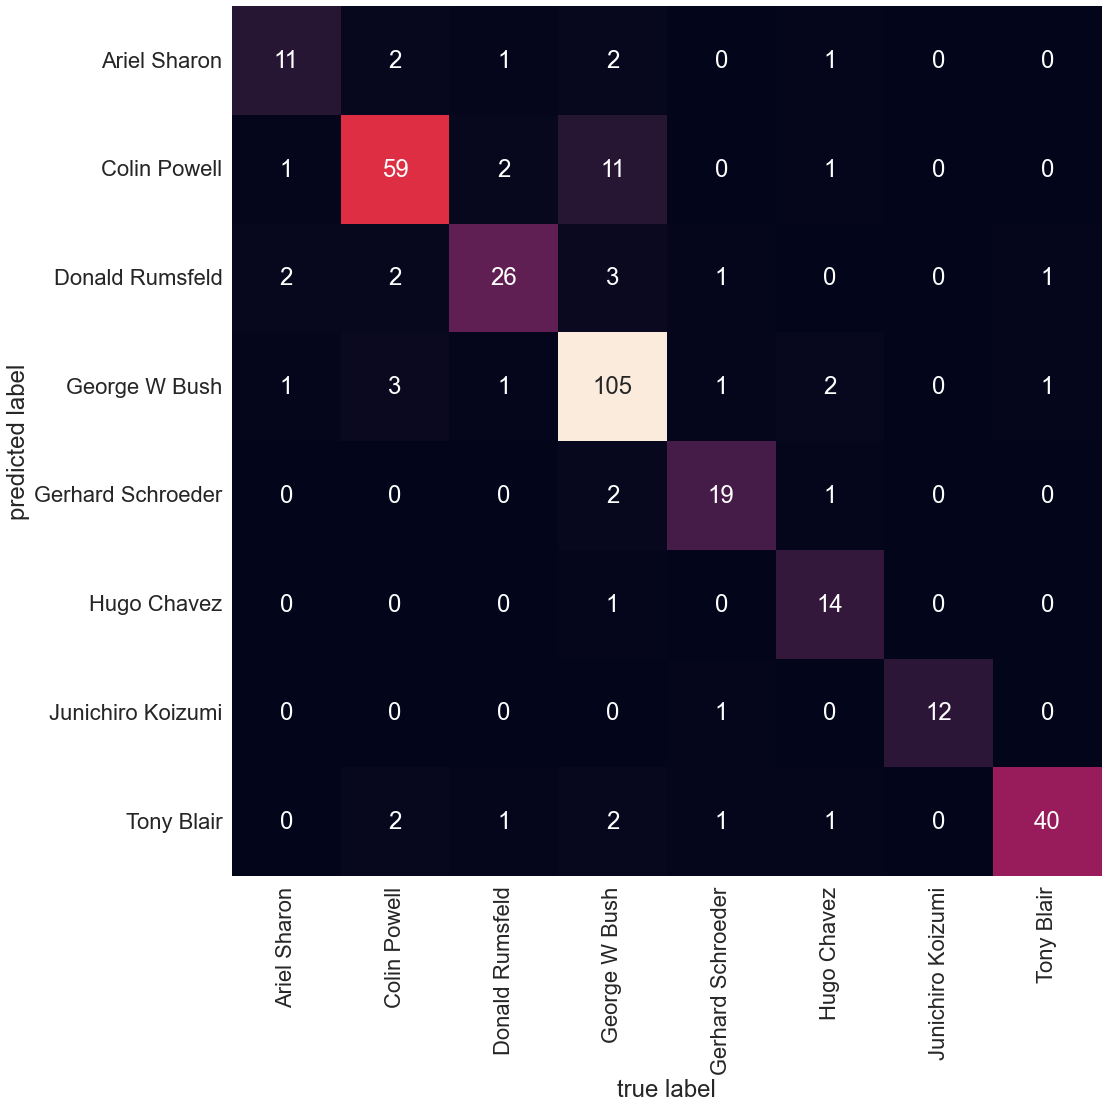

In [68]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.set(rc={'figure.figsize': (16, 16)})
sns.set(font_scale=2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

LFW数据集中的样本已经对人脸区域进行了截取。但对于一个实际的人脸识别任务，我们需要使用前置的算法找到对应的人脸区域。一个选择是利用[OpenCV](https://docs.opencv.org/4.x/d2/d99/tutorial_js_face_detection.html)，其中包括预训练好的人脸检测模型。

## 支持向量机总结

本次教程给出了使用Scikit-Learn中的**支持向量分类器SVC**对不同样本进行分类的示例。

支持向量机是一种强大的分类算法，其优点为:

1. 分类界面的构建仅依赖少数支持向量。

2. 结合核函数的SVM能够处理线性不可分的数据。

3. 预测阶段速度较快。



然而，支持向量机也有如下缺点:

1. 训练阶段的计算复杂度较高，通常位于$\mathcal{O}[N^2]$到$\mathcal{O}[N^3]$之间。（分析过程可以参考[这篇文章](https://leon.bottou.org/publications/pdf/lin-2006.pdf)第4.2节Complexity）

2. 不同的正则化参数$C$往往对模型性能有较大影响，需要通过交叉验证等方式进行手动选择。

3. 分类结果缺乏概率化的解释。